Variational Autoencoders (VAEs)
======

The VAE implemented here uses the setup found in most VAE papers: a multivariate Normal distribution for the conditional distribution of the latent vectors given and input image ($q_{\phi}(z | x_i)$ in the slides) and a multivariate Cernoulli distribution for the conditional distribution of images given the latent vector ($p_{\theta}(x | z)$ in the slides). Using a Cernoulli distribution, the reconstruction loss (negative log likelihood of a data point in the output distribution) reduces to the pixel-wise binary cross-entropy. See the [original VAE paper](https://arxiv.org/pdf/1312.6114.pdf), Appendix C.1 for details.

This code is from CreativeAI: Deep Learning for Graphics Tutorial [[Link]](https://github.com/smartgeometry-ucl/dl4g)

In [ ]:
!python --version

Python 3.9.16


In [ ]:
import sys
!pip install pytorch torchvision matplotlib

import sys
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
  error: subprocess-exited-with-error
  
  × Running setup.py install for pytorch did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for pytorch ... error
error: legacy-install-failure

× Encountered error while trying to install package.
╰─> pytorch

note: This is an issue with the package mentioned above, not pip.
hint: See above for output from the failure.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Hyperparameters
-----

In [ ]:
# 2-d latent space, parameter count in the same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True
A_savepath='/content/drive/MyDrive/Colab Notebooks/DATA303/A_vae_2d_100.pth'
B_savepath='/content/drive/MyDrive/Colab Notebooks/DATA303/B_vae_2d_100.pth'
C_savepath='/content/drive/MyDrive/Colab Notebooks/DATA303/C_vae_2d_100.pth'

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Using downloaded and verified file: ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 13597002.34it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25218390.45it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17024601.22it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



VAE Definition
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

Model A
-----------------------
VAE with Conv2d, ConvTranspose2d, kernel_size=4, stride=2, latent_dims=2

In [ ]:
class A_Encoder(nn.Module):
    def __init__(self):
        super(A_Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class A_Decoder(nn.Module):
    def __init__(self):
        super(A_Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using CCE as reconstruction loss
        return x
    
class A_VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(A_VariationalAutoencoder, self).__init__()
        self.encoder = A_Encoder()
        self.decoder = A_Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Cernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    
A_vae = A_VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
A_vae = A_vae.to(device)

num_params = sum(p.numel() for p in A_vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


Train VAE Model A
--------

In [ ]:
optimizer = torch.optim.Adam(params=A_vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
A_vae.train()

A_train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    A_train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = A_vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        A_train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    A_train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, A_train_loss_avg[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 23872.310589
Epoch [2 / 100] average reconstruction error: 21266.850020
Epoch [3 / 100] average reconstruction error: 20592.167727
Epoch [4 / 100] average reconstruction error: 20240.367829
Epoch [5 / 100] average reconstruction error: 20009.255916
Epoch [6 / 100] average reconstruction error: 19862.206654
Epoch [7 / 100] average reconstruction error: 19751.755443
Epoch [8 / 100] average reconstruction error: 19660.690707
Epoch [9 / 100] average reconstruction error: 19577.417255
Epoch [10 / 100] average reconstruction error: 19516.671554
Epoch [11 / 100] average reconstruction error: 19468.595651
Epoch [12 / 100] average reconstruction error: 19410.151503
Epoch [13 / 100] average reconstruction error: 19365.208791
Epoch [14 / 100] average reconstruction error: 19321.926866
Epoch [15 / 100] average reconstruction error: 19282.886929
Epoch [16 / 100] average reconstruction error: 19246.978118
Epoch [17 / 100] average reconstruct

Plot Training Curve about Model A
--------------------

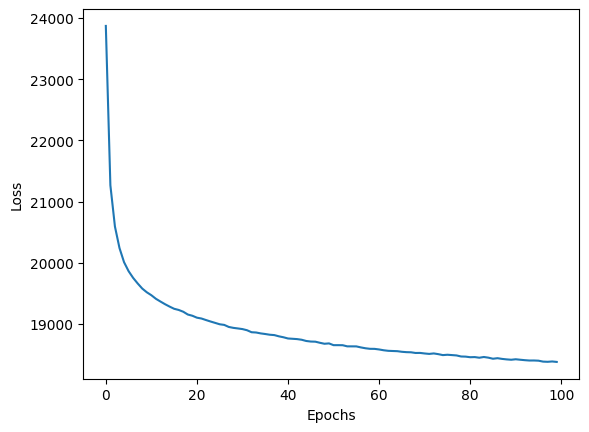

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(A_train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Evaluate Model A on Test Set
-----

In [ ]:
# set to evaluation mode
A_vae.eval()

A_test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = A_vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        A_test_loss_avg += loss.item()
        num_batches += 1
    
A_test_loss_avg /= num_batches
print('average reconstruction error: %f' % (A_test_loss_avg))

average reconstruction error: 19103.893533


In [ ]:
torch.save(A_vae.state_dict(), A_savepath)

In [ ]:
A_vae.load_state_dict(torch.load(A_savepath, map_location=torch.device('cpu')))

<All keys matched successfully>

Visualize Reconstructions of Model A
--------------------------

Original images


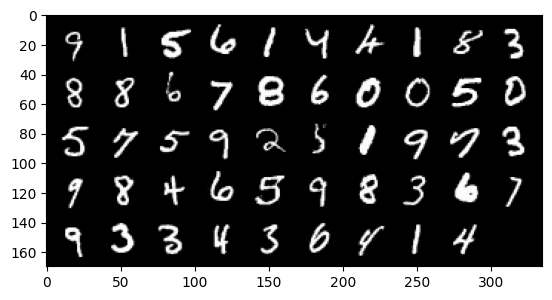

VAE reconstruction:


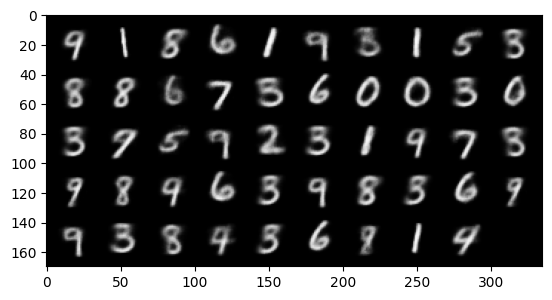

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

A_vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, A_vae)

Model B
-----------------------
Find a model that yields the "checkerboard artifacts"  
=> VAE with Conv2d, ConvTranspose2d, kernel_size=3, stride=2, latent_dims=2

In [ ]:
class B_Encoder(nn.Module):
    def __init__(self):
        super(B_Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=2, stride=2, padding=0) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=2, stride=2, padding=0) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class B_Decoder(nn.Module):
    def __init__(self):
        super(B_Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class B_VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(B_VariationalAutoencoder, self).__init__()
        self.encoder = B_Encoder()
        self.decoder = B_Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
B_vae = B_VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
B_vae = B_vae.to(device)

num_params = sum(p.numel() for p in B_vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 209285


Train VAE Model B
-----

In [ ]:
optimizer = torch.optim.Adam(params=B_vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
B_vae.train()

B_train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    B_train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = B_vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        B_train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    B_train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, B_train_loss_avg[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 24063.713728
Epoch [2 / 100] average reconstruction error: 21653.918583
Epoch [3 / 100] average reconstruction error: 21226.806099
Epoch [4 / 100] average reconstruction error: 20991.887083
Epoch [5 / 100] average reconstruction error: 20861.597129
Epoch [6 / 100] average reconstruction error: 20764.972715
Epoch [7 / 100] average reconstruction error: 20690.832554
Epoch [8 / 100] average reconstruction error: 20636.972977
Epoch [9 / 100] average reconstruction error: 20589.208393
Epoch [10 / 100] average reconstruction error: 20550.788844
Epoch [11 / 100] average reconstruction error: 20505.033670
Epoch [12 / 100] average reconstruction error: 20474.397261
Epoch [13 / 100] average reconstruction error: 20436.156539
Epoch [14 / 100] average reconstruction error: 20411.413190
Epoch [15 / 100] average reconstruction error: 20383.032412
Epoch [16 / 100] average reconstruction error: 20370.914787
Epoch [17 / 100] average reconstruct

Plot Training Curve about Model B
-----

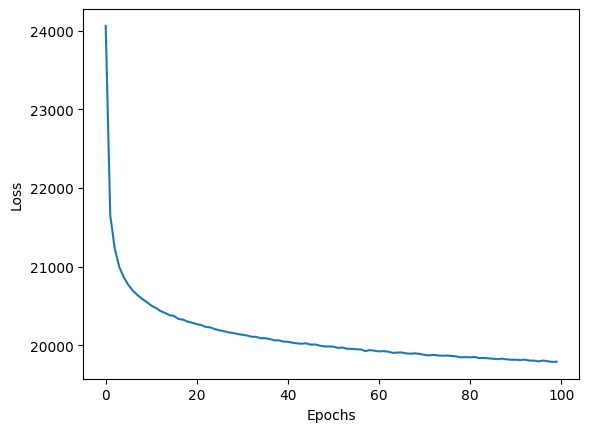

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(B_train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Evaluate Model B on Test Set
-----

In [ ]:
# set to evaluation mode
B_vae.eval()

B_test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = B_vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        B_test_loss_avg += loss.item()
        num_batches += 1
    
B_test_loss_avg /= num_batches
print('average reconstruction error: %f' % (B_test_loss_avg))

average reconstruction error: 19847.158080


In [ ]:
torch.save(B_vae.state_dict(), B_savepath)

Visualize Reconstructions of Model B
-----

Original images


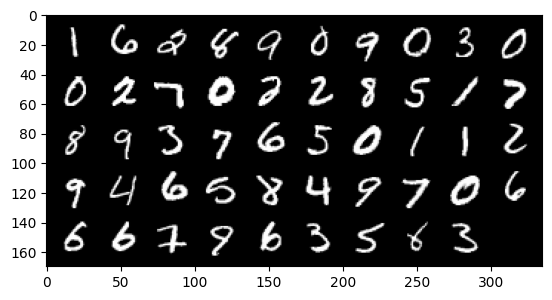

VAE reconstruction:


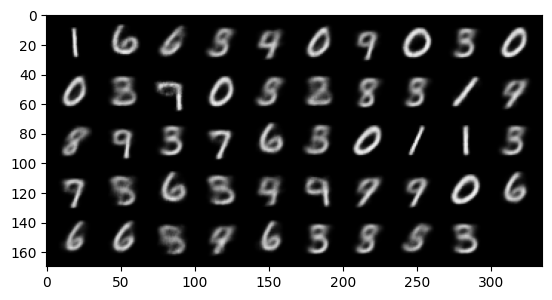

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

B_vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, B_vae)

We can see the "checkerboard artifacts" in reconstruction image

Model C
-----------------------
VAE with Conv2d, ConvTranspose2d, kernel_size=3, stride=2, latent_dims=10

In [ ]:
# set hyperparameter
C_latent_dims = 10

In [ ]:
class C_Encoder(nn.Module):
    def __init__(self):
        super(C_Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=3, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=3, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=C_latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=C_latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class C_Decoder(nn.Module):
    def __init__(self):
        super(C_Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=C_latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class C_VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(C_VariationalAutoencoder, self).__init__()
        self.encoder = C_Encoder()
        self.decoder = C_Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
C_vae = C_VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
C_vae = C_vae.to(device)

num_params = sum(p.numel() for p in C_vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 401109


Train VAE Model C
-----

In [ ]:
optimizer = torch.optim.Adam(params=C_vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
C_vae.train()

C_train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    C_train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = C_vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        C_train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    C_train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, C_train_loss_avg[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 18673.248178
Epoch [2 / 100] average reconstruction error: 15032.827598
Epoch [3 / 100] average reconstruction error: 14472.919820
Epoch [4 / 100] average reconstruction error: 14189.129548
Epoch [5 / 100] average reconstruction error: 13993.002259
Epoch [6 / 100] average reconstruction error: 13866.133733
Epoch [7 / 100] average reconstruction error: 13765.935341
Epoch [8 / 100] average reconstruction error: 13686.416661
Epoch [9 / 100] average reconstruction error: 13622.211402
Epoch [10 / 100] average reconstruction error: 13567.431753
Epoch [11 / 100] average reconstruction error: 13522.724945
Epoch [12 / 100] average reconstruction error: 13482.046057
Epoch [13 / 100] average reconstruction error: 13441.304402
Epoch [14 / 100] average reconstruction error: 13413.773431
Epoch [15 / 100] average reconstruction error: 13386.287078
Epoch [16 / 100] average reconstruction error: 13362.764180
Epoch [17 / 100] average reconstruct

Evaluate Model C on Test Set
-----

In [ ]:
# set to evaluation mode
C_vae.eval()

C_test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = C_vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        C_test_loss_avg += loss.item()
        num_batches += 1
    
C_test_loss_avg /= num_batches
print('average reconstruction error: %f' % (C_test_loss_avg))

average reconstruction error: 12270.789212


In [ ]:
torch.save(C_vae.state_dict(), C_savepath)

Visualize Reconstructions of Model C
--------------------------

Original images


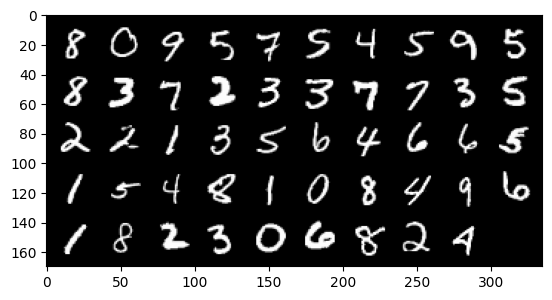

VAE reconstruction:


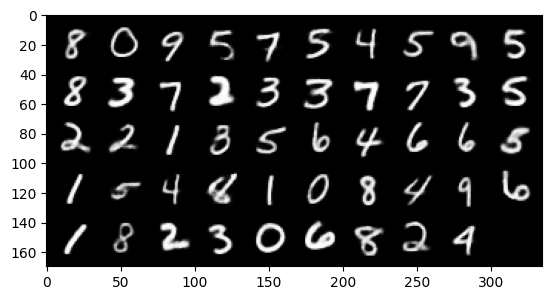

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

C_vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, C_vae)

Compare Model A, B, C
-----

In [ ]:
print('Average Reconstruction Error')
print('Model A: %f' % (A_test_loss_avg))
print('Model B: %f' % (B_test_loss_avg))
print('Model C: %f' % (C_test_loss_avg))

Average Reconstruction Error
Model A: 19103.893533
Model B: 19847.158080
Model C: 12270.789212


Model C has the lowest average reconstruction error, which implies that the high latent space is better than low latent space. Model B which has the checkerboard artifacts is worse that Model A.

Interpolation in Latent Space of Model A
-----


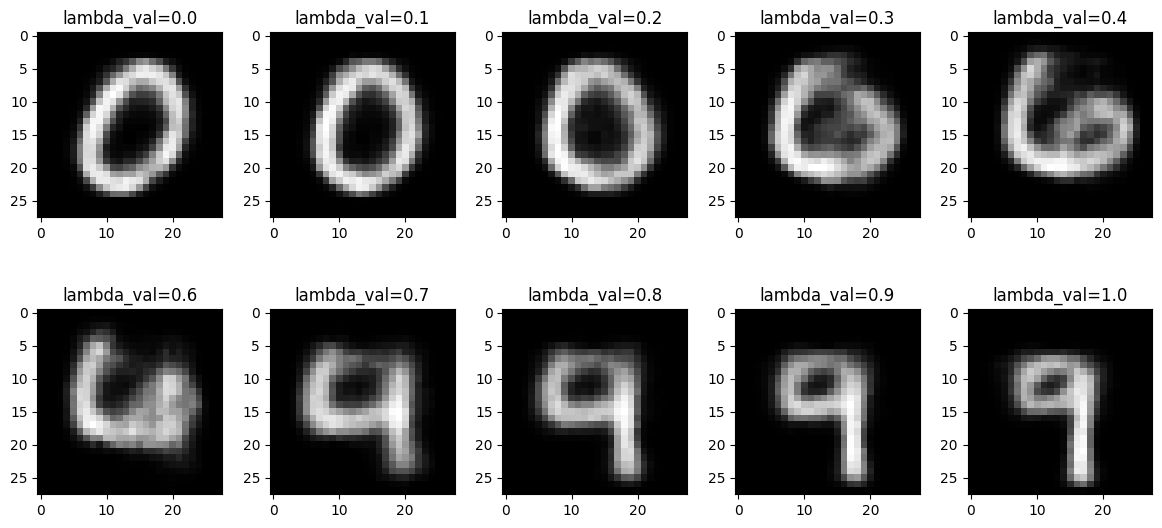

In [ ]:
A_vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind, l in enumerate(lambda_range):
    inter_image=interpolation(float(l), A_vae, digits[9][9], digits[0][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))

plt.show() 

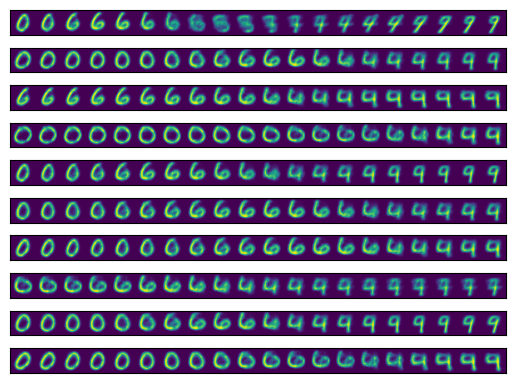

In [ ]:
A_vae.eval()

def interpolate(vae, images, labels, n):
    with torch.no_grad():
        latent_mu, latent_logvar = vae.encoder(images)
        z = vae.latent_sample(latent_mu, latent_logvar)
        
        z_0 = z[labels == 0][1]
        z_9 = z[labels == 9][1]
        z = torch.stack([z_0 + (z_9 - z_0)*t for t in np.linspace(0, 1, n)])
        interpolate_list = vae.decoder(z)
        interpolate_list = interpolate_list.to('cpu').detach().numpy()

        return interpolate_list

width = 28
n = 20
rep = 10
for i in range(rep):
    plt.subplot(rep, 1, i+1)
    images, labels = next(iter(test_dataloader))
    interpolate_list = interpolate(A_vae, images.to(device), labels, n)
    img = np.zeros((width, n*width))
    for j, x_hat in enumerate(interpolate_list):
        img[:, j*width:(j+1)*width] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])


Latent space is a high-dimensional space, so the decoder result can be significantly different even with a slight change.  
The loaded images are different for each iteration. Therefore, different results are obtained.



Sample Latent Vector from Prior (VAE as Generator)
-------------------------------------------------

A VAE can generate new digits by drawing latent vectors from the prior distribution. Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder (compare results for the 10d VAE to the results for the autoencoder).

Similar to autoencoders, the manifold of latent vectors that decode to valid digits is sparser in higher-dimensional latent spaces. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction. A pre-trained model with `variational_beta = 10` is available at `./pretrained/vae_10d_beta10.pth`.

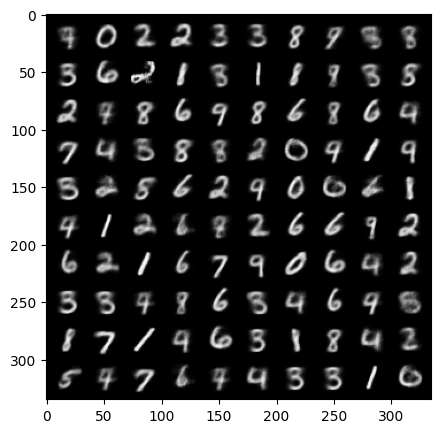

In [ ]:
A_vae.eval()

with torch.no_grad():

    # sample latent vectors from the prior (Gaussian) distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = A_vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

Sample Latent Vector from Estimated Gaussian
-----

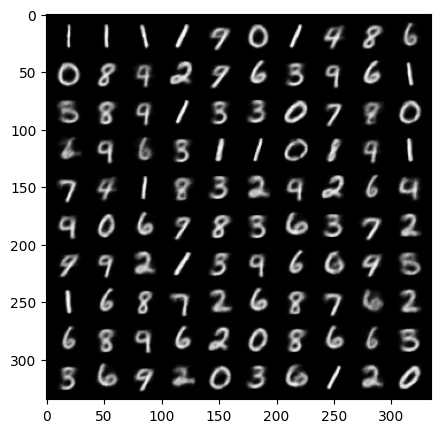

In [ ]:
images, labels = next(iter(test_dataloader))

A_vae.eval()

with torch.no_grad():

    # sample latent vectors from the estimated Gaussian distribution
    latent, _ = A_vae.encoder(images)

    # reconstruct images from the latent vectors
    img_recon = A_vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

2D Latent Space from Prior
-----

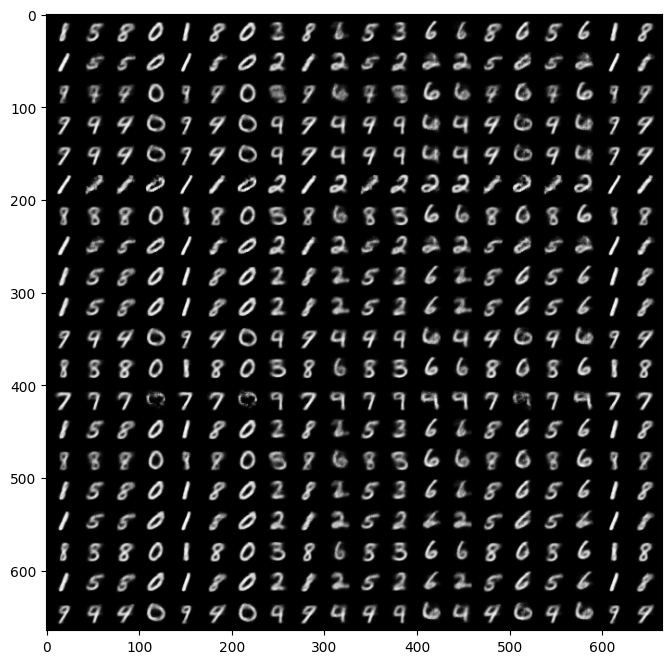

In [ ]:
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.random.normal(0, 1, 20)
    latent_y = np.random.normal(0, 1, 20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = A_vae.decoder(latents)
    image_recon = image_recon.cpu()
    
    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()

2D Latent Space from the distribution
-----

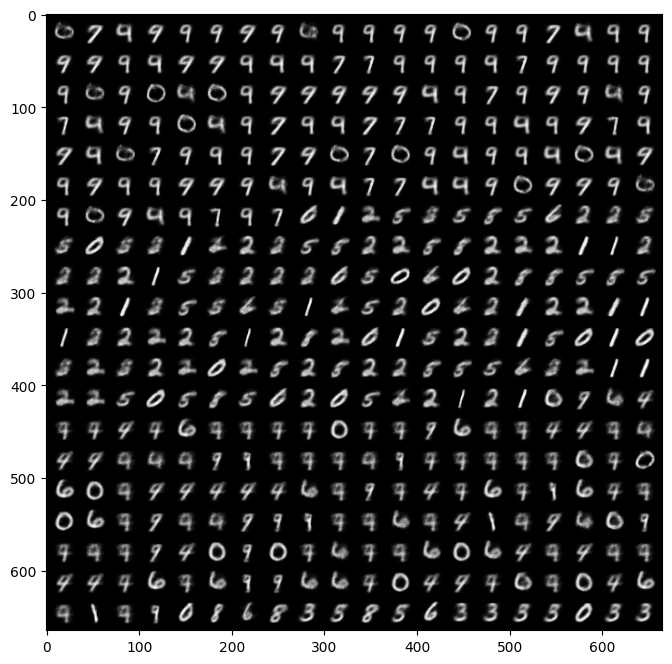

In [ ]:
images, labels = next(iter(test_dataloader))

with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_mu, latent_logvar = A_vae.encoder(images)
    latent_std = latent_logvar.mul(0.5).exp_()
    latent_x = [np.random.normal(mu, std)[0] for mu, std in zip(latent_mu, latent_std)]
    latent_y = [np.random.normal(mu, std)[0] for mu, std in zip(latent_mu, latent_std)]
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = A_vae.decoder(latents)
    image_recon = image_recon.cpu()
    
    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()

In [52]:
from google.colab import drive, files
from requests import get
from urllib.parse import unquote

drive.mount('/mnt/')
filename = unquote(get('http://172.28.0.12:9000/api/sessions').json()[0]['name'])
filepath = f'/mnt/My Drive/Colab Notebooks/{filename}'
output_file = '/content/Assignment2.html'

!jupyter nbconvert '{filepath}' --to html --output '{output_file}'
files.download(output_file) 

Mounted at /mnt/
[NbConvertApp] Converting notebook /mnt/My Drive/Colab Notebooks/Variational_Autoencoders.ipynb to html
[NbConvertApp] Writing 2645960 bytes to /content/Assignment2.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>